#  Predict the stock prices of Microsoft 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set()
plt.style.use('fivethirtyeight')

MSFT = pd.read_csv("data/MSFT.csv")
BTC = pd.read_csv("data/BTC-USD.csv")
BTC.dropna(inplace=True)
print(MSFT.head())
print(BTC.head())

         Date        Open        High         Low       Close   Adj Close   
0  2023-03-01  250.759995  250.929993  245.789993  246.270004  244.265244  \
1  2023-03-02  246.550003  251.399994  245.610001  251.110001  249.065857   
2  2023-03-03  252.190002  255.619995  251.389999  255.289993  253.211807   
3  2023-03-06  256.429993  260.119995  255.979996  256.869995  254.778931   
4  2023-03-07  256.299988  257.690002  253.389999  254.149994  252.081085   

     Volume  
0  27565300  
1  24808200  
2  30760100  
3  24109800  
4  21473200  
         Date        Open        High         Low       Close   Adj Close   
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015  \
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.8

In this dataset, the Close column contains the values whose future values we want to predict. So let’s have a closer look at the historical close prices of Microsoft’s stock price:

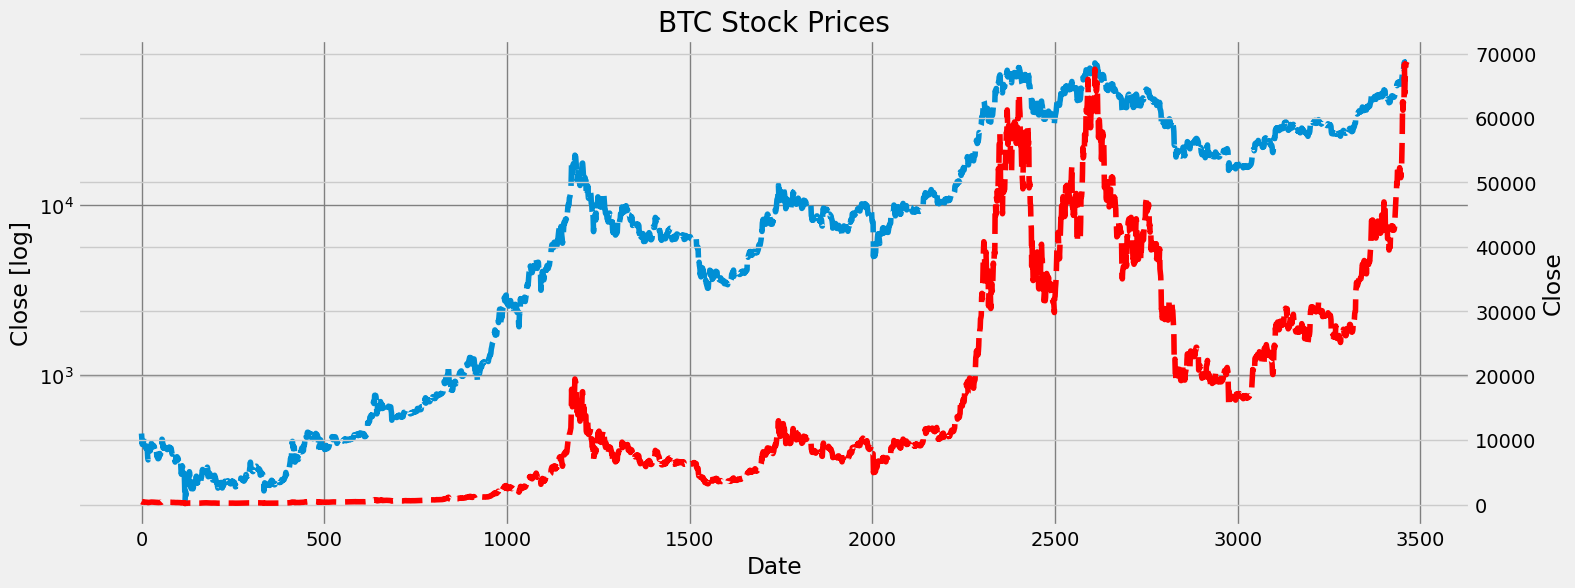

In [16]:
#btc_close = BTC.query('Date > "2023-09-21"')

fig, ax = plt.subplots(figsize=(16, 6))


ax.set_title("BTC Stock Prices")
ax.set_xlabel("Date")
ax.set_yscale('log')
ax.set_ylabel("Close [log]")
ax.plot(BTC["Close"], linestyle = '--')
ax.grid(color='gray')
ax2 = ax.twinx()
ax2.set_ylabel("Close")
ax2.plot(BTC["Close"], color='red', linestyle = '--')


plt.show()

In [17]:
data_no_time = BTC[[ 'Open', 'High', 'Low', 'Close', 'Adj Close']]

               Open      High       Low     Close  Adj Close
Open       1.000000  0.999489  0.999136  0.998847   0.998847
High       0.999489  1.000000  0.998967  0.999488   0.999488
Low        0.999136  0.998967  1.000000  0.999380   0.999380
Close      0.998847  0.999488  0.999380  1.000000   1.000000
Adj Close  0.998847  0.999488  0.999380  1.000000   1.000000


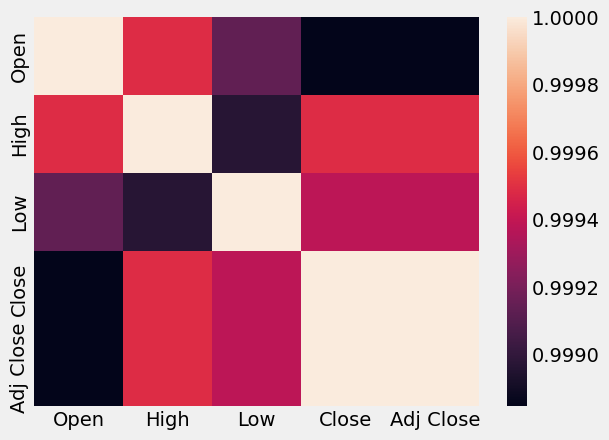

In [18]:
print(data_no_time.corr())
sns.heatmap(data_no_time.corr())
plt.show()

<Axes: >

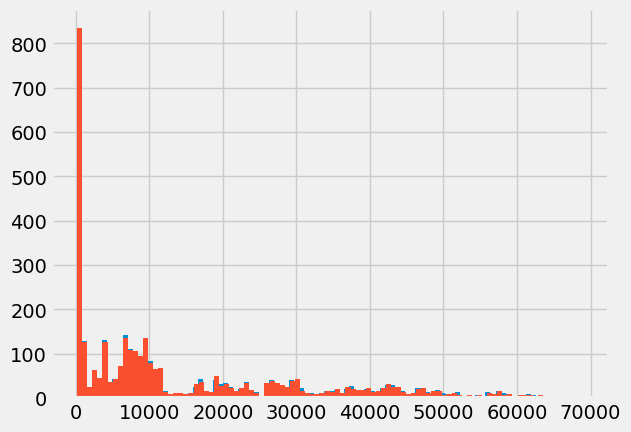

In [19]:
BTC.Close.hist(bins=100)
BTC.Open.hist(bins=100)

Now I’ll prepare the data to fit into the machine learning model. In this step, I will first add the most important features to x and the target column to y, and then I will divide the dataset into training and test sets:

In [20]:
x = BTC[["Open", "High", "Low"]]
y = BTC["Close"]

x = x.to_numpy()
y = y.to_numpy()
y = y.reshape(-1, 1)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
y

array([[  457.334015],
       [  424.440002],
       [  394.79599 ],
       ...,
       [68300.09375 ],
       [68498.882813],
       [68732.421875]])

# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(xtrain, ytrain)
ypred_tree = tree.predict(xtest)
Tree_predict = pd.DataFrame(data={"Predicted": ypred_tree,
                                "True": ytest[:,0]})
Tree_predict.head()

,Predicted,True
0,44348.730469,43943.097656
1,322.022003,325.431000
2,40127.183594,40077.074219
3,3648.430664,3661.301025
4,8716.790039,8879.620117


Mean Squared Error: 277975.7410358969


<Axes: >

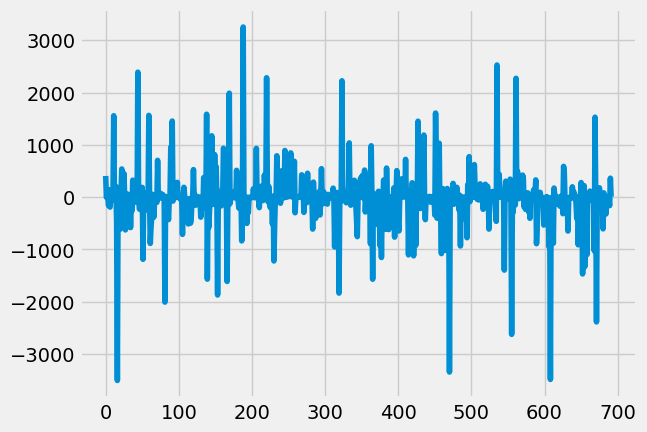

In [23]:
mse = mean_squared_error(ytest, ypred_tree)
print(f'Mean Squared Error: {mse}')
(Tree_predict['Predicted'] - Tree_predict['True']).plot()

# XGBoost

paper : https://www.jstor.org/stable/2699986 

doc : https://xgboost.readthedocs.io/

In [24]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor()
model_xgb.fit(xtrain, ytrain)

y_pred_xgb = model_xgb.predict(xtest)

Mean Squared Error: 212187.9611802428


<Axes: >

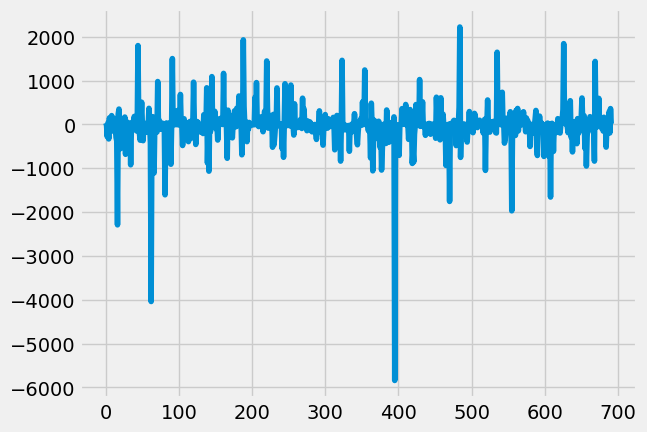

In [25]:
mse = mean_squared_error(ytest, y_pred_xgb)
print(f'Mean Squared Error: {mse}')

XGB_predict_CV = pd.DataFrame(data={"Predicted": y_pred_xgb,
                                "True": ytest[:,0]})
(XGB_predict_CV['Predicted'] - XGB_predict_CV['True']).plot()

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


model_xgb = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(xtrain, ytrain)
print("Mejores hiperparámetros:", grid_result.best_params_)

Mejores hiperparámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8}


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model_xgb = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(xtrain, ytrain)
print("Mejores hiperparámetros:", grid_result.best_params_)

In [28]:

print("Mejores hiperparámetros:", grid_result.best_params_)

Mejores hiperparámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8}


In [29]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [7, 9, 15],
    'min_child_weight': [2, 3, 4],
    'gamma': [0],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [1.0]
}

model_xgb = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(xtrain, ytrain)
print("Mejores hiperparámetros:", grid_result.best_params_)

Mejores hiperparámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7}


MSE con regularización: 176076.4300182472


<Axes: >

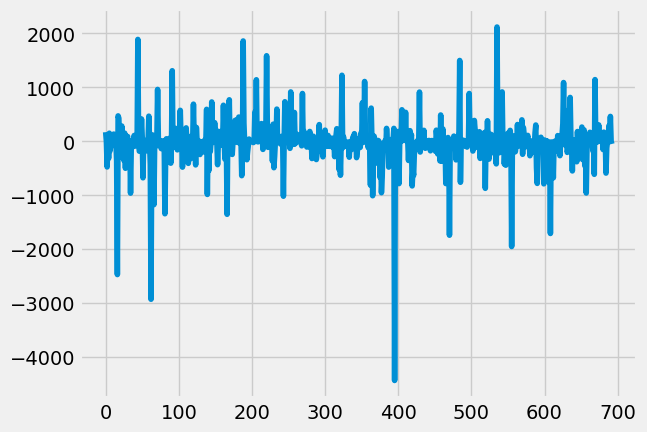

In [30]:
model_reg = xgb.XGBRegressor(colsample_bytree= 1.0, 
                             gamma =  0, 
                             learning_rate = 0.1, 
                             max_depth= 7, 
                             min_child_weight= 2, 
                             subsample = 0.7)

model_reg.fit(xtrain, ytrain)
y_pred_XGB_reg = model_reg.predict(xtest)
mse_xgb_CV = mean_squared_error(ytest, y_pred_XGB_reg)

print(f'MSE con regularización: {mse_reg}')
XGB_predict_CV = pd.DataFrame(data={"Predicted": y_pred_XGB_reg,
                                "True": ytest[:,0]})
(XGB_predict_CV['Predicted'] - XGB_predict_CV['True']).plot()

# Gaussian Process

In [ ]:
#

# Neural Networks

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

In [48]:
# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(BTC.drop(['Date'], axis=1))

# Dividir los datos en características (features) y etiquetas (labels)
X = scaled_data[:, :-1]
y = scaled_data[:, -1]

# Convertir los datos a tensores de PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, X_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Crear DataLoader para manejar los datos
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = TensorDataset(X_test, X_test)
test_loader = DataLoader(test_data, batch_size=64)

In [49]:
# Definir la arquitectura de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inicializar la red neuronal
input_size = X_train.shape[1]
model_nn = NeuralNetwork(input_size)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

In [50]:
# Entrenar la red neuronal
num_epochs = 1000
for epoch in range(num_epochs):
    train_loss = 0.0  # Pérdida acumulada en el conjunto de entrenamiento
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)  # Multiplica la pérdida por el tamaño del lote

    # Calcular la pérdida media en el conjunto de entrenamiento
    train_loss /= len(train_loader.dataset)

    if (epoch+1) % 25 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

    # Evaluar el modelo en el conjunto de prueba
    test_loss = 0.0  # Pérdida acumulada en el conjunto de prueba
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model_nn(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            test_loss += loss.item() * inputs.size(0)  # Multiplica la pérdida por el tamaño del lote

    # Calcular la pérdida media en el conjunto de prueba
    test_loss /= len(test_loader.dataset)

    if (epoch+1) % 25 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x64 and 5x64)